In [ ]:
import pandas as pd
import tensorflow
import keras

df = pd.read_csv('/content/drive/MyDrive/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


In [ ]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_text(row))
df.head()

,en,fr
0,youre very clever,vous etes fort ingenieuse
1,are there kids,y atil des enfants
2,come in,entrez
3,wheres boston,ou est boston
4,you see what i mean,vous voyez ce que je veux dire


In [ ]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')

Max phrase length (English): 7
Max phrase length (French): 14


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=en_max_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=fr_max_len, padding='post')

In [ ]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12195


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Embedding(en_vocab_size, 256, input_length=en_max_len, mask_zero=True))
model.add(LSTM(256))
# Use sequence_len instead of fr_max_len to match fr_y's shape
model.add(RepeatVector(fr_max_len))  # Change here
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)                    │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_1 (LSTM)                              │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_2 (LSTM)                              │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ ?                               │       0 (unbuilt) │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ time_distributed (TimeDistributed)         │ ?                               │       0 (unbuilt) │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
hist = model.fit(en_x, fr_y, epochs=30, batch_size=50, validation_split=0.2, callbacks=[callback])

Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.9114 - loss: 0.2994 - val_accuracy: 0.8368 - val_loss: 1.0530
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.9136 - loss: 0.2913 - val_accuracy: 0.8354 - val_loss: 1.0516
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - accuracy: 0.9140 - loss: 0.2899 - val_accuracy: 0.8358 - val_loss: 1.0590
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.9151 - loss: 0.2840 - val_accuracy: 0.8351 - val_loss: 1.0623
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.9164 - loss: 0.2780 - val_accuracy: 0.8366 - val_loss: 1.0697
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - accuracy: 0.9174 - loss: 0.2741 - val_accuracy: 0.8369 - val_loss: 1.0774
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.9184 - loss: 0.2703 - val_accuracy: 0.8370 - val_loss: 1.0748
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.9191 - loss: 0.2677 - 

[]

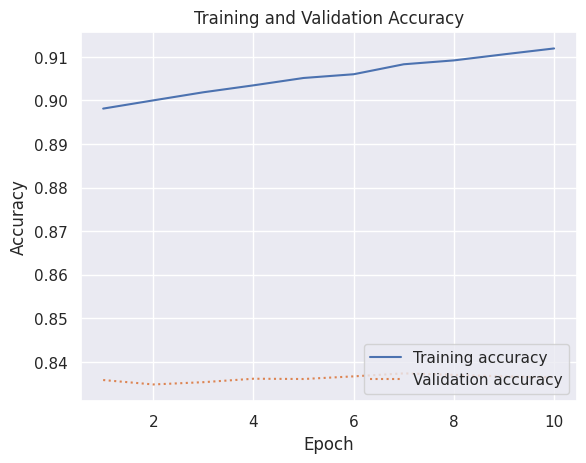

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len):
    sequence = en_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=en_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    return fr_tokenizer.sequences_to_texts([indexes])[0]

texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, en_max_len)
    print(f'{text} => {translated}')

its fall now => cest est bon
im losing => je suis en
it was quite funny => ce fut plutot amusant
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que ca fait cela
tom looks different => tom a lair different
its worth a try => ca vaut de coup dessayer
fortune smiled on him => la chance la a souri
lets hit the road => cassonsnous
i love winning => jadore gagner


In [ ]:
translate_text('Hello world', model, en_tokenizer, fr_tokenizer, en_max_len)

'salut le monde'